신경망 모델로는 주로 분류(classification)문제를 다루는데 사용하지만 이번에는 회귀(regression)문제에 사용해보겠습니다.

## The Boston Housing Price dataset

1970년대 중반의 보스톤 근교의 집 가격과 관련된 13개의 피처들에 대한 데이터로 집 가격을 최대한 정확하게 예측하는 회귀 모델을 만들어보겠습니다.

13개의 피처들은 내용은 다음과 같습니다.

- 범죄율은 낮을 수록 집 값이 높을 것이라고 예상할 수 있습니다.
- 학생/교사 비율은 높을 수록 집 값을 낮을 수도 있겠습니다.

CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS proportion of non-retail business acres per town

CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT % lower status of the population

## 데이터 가져오기

In [200]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

### 데이터 확인하기

In [201]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [202]:
train_targets.shape, test_targets.shape

((404,), (102,))

In [203]:
train_data[0], train_targets[0]

(array([   1.23247,    0.     ,    8.14   ,    0.     ,    0.538  ,
           6.142  ,   91.7    ,    3.9769 ,    4.     ,  307.     ,
          21.     ,  396.9    ,   18.72   ]), 15.199999999999999)

## 데이터 전처리: 정규화
- 앞선 실습에서 MNIST 데이터에서 사용한 정규화는 피처의 최소값, 최대값을 사용해서 피처값이 0에서 1사이의 값을 가지도록 정규화를 했습니다.
- 이번에는 각 피처의 평균과 표준편차를 사용해서 표준 정규화를 해보겠습니다.
- 그 후에 표준 정규화를 scikit-learn 에 있는 표준 정규화 클래스를 사용해서 해보겠습니다.
- 표준 정규화를 하면 데이터의 값은 대부분 -2 에서 +2 사이의 값이 됩니다.

In [204]:
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)

train_X = train_data.copy()
test_X  = test_data.copy()

train_X = train_X - mean
train_X = train_X / std

test_X  = test_X - mean
test_X  = test_X / std

In [205]:
train_X[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

이번엔 sklearn 에 있는 정규화 클래스를 사용해서 같은 작업을 해보겠습니다.

In [206]:
from sklearn.preprocessing import StandardScaler

In [207]:
scaler = StandardScaler()
scaler.fit(train_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [208]:
train_X = scaler.transform(train_data)
train_X[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

위에서 정규화한 결과와 방금 사이킷런의 StandardScaler 를 사용한 정규과의 결과가 같지 않습니까?

StandardScaler 클랫를 사용하면 더 편하고 재사용이 가능한 정규화 모델을 만들 수 있습니다.

머신러닝에서의 정규화는 다양한 범위의 피처(변수)들을 일정한 범위내의 값들로 스케일을 조절하는 기능을 합니다.

왜 MinMaxScaler 보다 StandardScaler 가 더 좋은 선택인지 생각해보면 좋을 것 같습니다.

훈련 데이터로 정규화한 StandardScaler 의 인스턴스로 테스트셋의 입력데이터도 정규화해두겠습니다.

In [209]:
test_X = scaler.transform(test_data)

## 회귀에 대한 신경망 쌓기

- 활성함수: ReLU
- 옵티마이저: adam
- 손실함수: mse, mean square error
- 평가지수: mae, mean absolute error

In [210]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_X.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # mse : mean square error,  mae : mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold 검증
- 데이터를 K 등분해서 각 1/K 에 해당하는 데이터를 테스트셋으로 사용함
- 전체 데이터셋이 작은 경우 K-fold 검증을 많이 사용함
- 아래의 방법은 `from sklearn.model_selection import KFold`를 사용하면 더 편하게 코딩할 수 있음

In [211]:
import numpy as np

# 훈련셋을 4 등분해서 한 부분을 테스트에 사용하고 나머지 세 부분을 훈련에 사용
k_fold = 4
# 훈련셋을 k_fold 등분 했을 때 한 부분의 길이
num_val_samples = len(train_X) // k_fold
# 훈련 에폭
epochs = 10
# 각 k_fold 로 나눈 데이터들을 훈련시킨 결과를 저장
all_scores = list()

for i in range(k_fold):
    print('Processing fold # {}'.format(i+1))
    
    # 검증 데이터 준비
    val_data    = train_X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 훈련 데이터 준비
    partial_train_data = np.concatenate(
        [train_X[:i * num_val_samples],
         train_X[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)   
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
                 epochs=epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
print("Done!")

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4
Done!


In [212]:
all_scores

[2.4789228698994852, 2.5854188003162348, 2.551139253200871, 2.8047156286711741]

In [213]:
np.mean(all_scores)

2.6050491380219412

집 가격의 편차가 2.6 정도 난다는 의미로 해석할 수 있습니다.

## 위의 코드를 sklearn 의 KFold 를 사용해서 간단하게 

In [214]:
import numpy as np

def kfold_cross_validation_for_linear_model(data, epochs=100, n_splits=4):
    all_scores = list()
    kf = KFold(n_splits=n_splits)
    
    for i, (train_index, test_index) in enumerate(kf.split(data), 1):
        print('Processing fold # {}'.format(i))
        
        # 훈련 데이터
        partial_train_data    = train_X[train_index]
        partial_train_targets = train_targets[train_index]
        
        # 검증 데이터 
        val_data       = train_X[test_index]
        val_targets    = train_targets[test_index]
        
        keras_model      = build_model()
        # 훈련 후에 교차검증을 실행
        # history.history.keys() 
        # ['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error']
        history = keras_model.fit(partial_train_data, partial_train_targets,
                             validation_data=(val_data, val_targets),
                             epochs=epochs, batch_size=1, verbose=0)
          
        mae_history = history.history['val_mean_absolute_error']
        all_scores.append(mae_history)

    print("Done!")
    return all_scores
    

In [215]:
all_scores = kfold_cross_validation_for_linear_model(train_X, epochs=10)

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4
Done!


In [216]:
all_scores[0]

[4.0694417859068013,
 3.2509861842240437,
 2.8881000953145546,
 3.1013876660035389,
 2.9786111151818,
 2.47048290177147,
 2.8827010711820997,
 2.2830504332438553,
 2.3164345675175735,
 2.1662089470589514]

In [217]:
np.mean(all_scores)

3.0577701677190197

코드가 좀 더 깔끔해졌습니다.

이번에는 200 epochs 만큼 훈련을 시키면서 모델에 대한 평가를 기록해보겠습니다.

In [218]:
from keras import backend as K

# Some memory clean-up
# K.clear_session()

In [228]:
all_scores = kfold_cross_validation_for_linear_model(train_X, epochs=500)

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4
Done!


In [229]:
all_mae_histories = all_scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(len(all_mae_histories[0]))]


In [230]:
len(all_mae_histories),len(average_mae_history)

(4, 500)

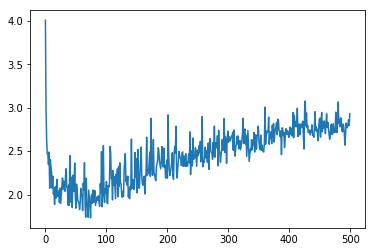

In [233]:
import matplotlib.pyplot as plt
plt.plot(range(len(all_mae_histories[0])), all_mae_histories[0])
plt.show()

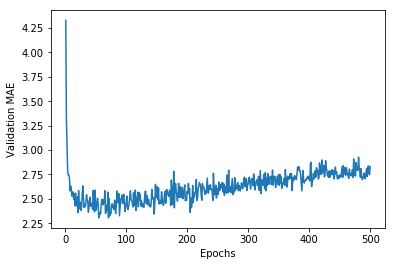

In [234]:


plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

히스토리의 처음 수치는 스케일이 다르므로 앞의 5개의 데이터를 제외한 상태에서 exponential moving average 를 구해서 그래프로 그려보겠습니다.

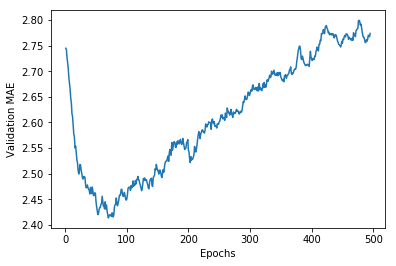

In [236]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[5:])

plt.plot(range(1, len(smooth_mae_history) +1 ), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

epoch 이 80 정도 이상에서는 오버피팅이 발생했다고 여겨진다.